###DOWNLOAD THE DATA SET


In [ ]:
pip install numpy matplotlib torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
! pip install -q kaggle

In [ ]:
 import os
 from google.colab import files



In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"kiri99126","key":"f47bf3376b0b43110c77d16665cfa946"}'}

In [ ]:
 ! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

In [ ]:
zip_ref = zipfile.ZipFile('flowers-recognition.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

###IMPORT THE DATA

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Description about the data

In [ ]:
data_dir='./flowers'
print("Classes in the data:",os.listdir(data_dir))

Classes in the data: ['tulip', 'dandelion', 'sunflower', 'daisy', 'rose']


In [ ]:
for cls in os.listdir(data_dir):
  print(cls,len(os.listdir(data_dir+'/'+cls)))

tulip 984
dandelion 1052
sunflower 733
daisy 764
rose 784


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
dataset=ImageFolder(data_dir)

In [ ]:
len(dataset)

4317

To display an image

Size of the image: (320, 263)
Label of the image is: 0


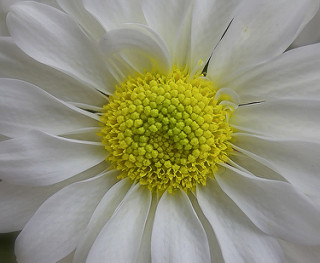

In [ ]:
img,label=dataset[0]
print("Size of the image:",img.size)
print("Label of the image is:",label)
img

Size of the image: (320, 274)
Label of the image is: 1


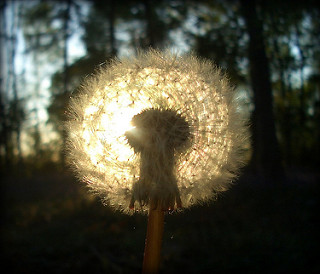

In [ ]:
img,label=dataset[1500]
print("Size of the image:",img.size)
print("Label of the image is:",label)
img

All the images are of different size

Compose if used to apply bunch of transformations in order

In [ ]:
def show_img(img, label):
  plt.imshow(img.permute(1,2,0))
  print("Label of the image :",dataset.classes[label])

In [ ]:
import torchvision.transforms as transforms
transform = transforms.Compose([
                transforms.Resize(size=(64)),
                transforms.RandomCrop(64),
                transforms.ToTensor()
])



Size of image is: (320, 263)
Shape of transformed image is: torch.Size([3, 64, 64])
Label of the image : daisy


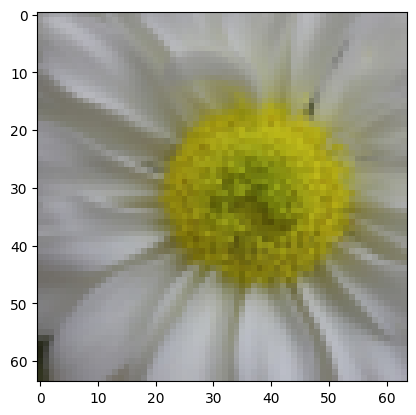

In [ ]:
img,label=dataset[0]
print("Size of image is:",img.size)
transformed_img=transform(img)
print("Shape of transformed image is:",transformed_img.shape)
show_img(transformed_img,label)

Size of image is: (240, 240)
Shape of transformed image is: torch.Size([3, 64, 64])
Label of the image : dandelion


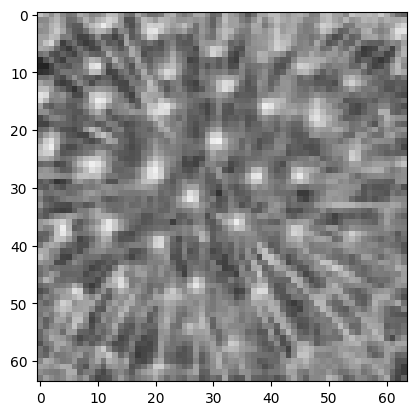

In [ ]:
img,label=dataset[990]
print("Size of image is:",img.size)
transformed_img=transform(img)
print("Shape of transformed image is:",transformed_img.shape)
show_img(transformed_img,label)

In [ ]:
from torchvision import datasets
dataset = datasets.ImageFolder(root='/content/flowers', transform=transform)

#Training and Validation sets


In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
val_size=310
train_size=len(dataset)-val_size
train_ds , val_ds= random_split(dataset,[train_size,val_size])
print("Train size:",train_size)
print("Validation size:",val_size)

Train size: 4007
Validation size: 310


In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size=64

In [ ]:
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)
val_dl = DataLoader(val_ds,
                    batch_size*2,
                    num_workers=2,
                    pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

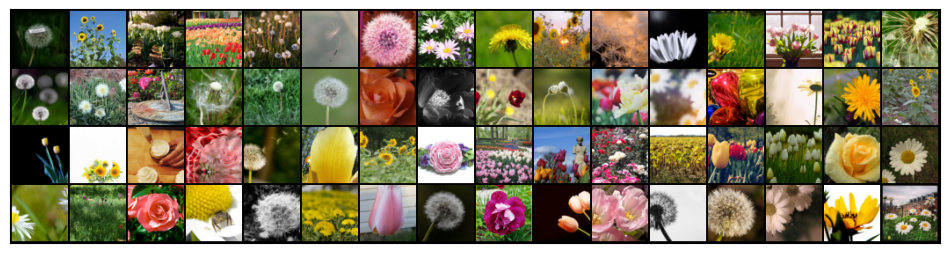

In [ ]:
show_batch(train_dl)

#Helper functions

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
      return torch.device('cuda')
      #Returns a pointer to cuda
    else:
      return torch.device('cpu')
      #Returns a pointer to cpu

def to_device(data, device):
    #Data can be a tensor or a model
    #Move tensors to chosen device
    if isinstance(data, (list,tuple)):
      return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
      #Wrap a dataloader to move data to a device
      def __init__(self, dl, device):
        self.dl = dl
        self.device = device

      def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl:
          yield to_device(b, self.device)

      def __len__(self):
        #Returns number of batches of data within the dataloader
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
for images, labels in train_dl:
  print(images.shape)
  print("Initial location of image:",images.device)
  images = to_device(images, device)
  print("After moving to required device:",images.device)
  break

torch.Size([64, 3, 64, 64])
Initial location of image: cpu
After moving to required device: cuda:0


In [ ]:
#It will trap the training data loader and the device
train_loader = DeviceDataLoader(train_dl, device)
#It will trap the validation data loader and the device
val_loader = DeviceDataLoader(val_dl, device)

train_dl , val_dl are dataloaders in cpu
train_loader , val_loader are dataloaders in cuda

In [ ]:
for xb, yb in val_dl:
    print('xb.device:', xb.device)
    break

xb.device: cpu


#Defining the model

Defining image classification Base Class

In [ ]:
class ImageClassificationBase(nn.Module):

    #return loss for a batch of training data
    def training_step(self, batch):
        images, labels = batch
        #internally invokes forward method of the model to calculate predictions
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    #to calculate loss and accuracy within 1 batch of data
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        #return an object or dictionary of loss and accuacay
        return {'val_loss': loss.detach(), 'val_acc': acc}

    #retruns overall validation loss and validation accuracy for the entire validation set
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    #simply to print
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

NameError: name 'nn' is not defined

#RESNET ARCHITECTURE







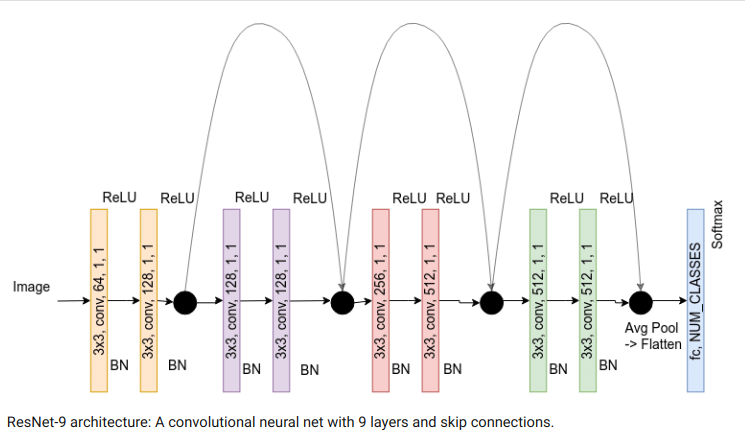

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #Input 64*3*64*64
        self.conv1 = conv_block(in_channels, 64)
        #Output 64*64*64*64
        self.conv2 = conv_block(64, 128, pool=True)
        #Output 64*128*32*32
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        #Output 64*128*32*32
        self.conv3 = conv_block(128, 256, pool=True)
        #Output 64*256*16*16
        self.conv4 = conv_block(256, 512, pool=True)
        #Output 64*512*8*8
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        #Output 64*512*8*8
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), #Output : 64*512*1*1
                                        nn.Flatten(), #Output : 64*512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes)
                                        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        out=F.softmax(out,dim=1)
        return out

NameError: name 'ImageClassificationBase' is not defined

Moving the model to the same device as data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = to_device(ResNet9(3, 5), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Defining Evaluate and fit functions for the model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
test_resnet = to_device(ResNet9(3,5), device)
num_classes=5
for images, labels in train_dl:
    print(images.shape)
    print("Initial location of image:",images.device)
    images = to_device(images, device)
    print("After moving to required device:",images.device)
    out = test_resnet(images)
    print("Outputs shape:",out.shape)
    break
del test_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([64, 3, 64, 64])
Initial location of image: cpu
After moving to required device: cuda:0
Outputs shape: torch.Size([64, 5])


#Training the model


In [ ]:
history=[]
history=evaluate(model, val_loader)
history

{'val_loss': 1.6089332103729248, 'val_acc': 0.17988039553165436}

In [ ]:
history=[]
num_epochs = 6
opt_func = torch.optim.Adam
lr = 0.001
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)



Epoch [0], train_loss: 1.2893, val_loss: 0.9740, val_acc: 0.6012
Epoch [1], train_loss: 0.9678, val_loss: 0.8329, val_acc: 0.6841
Epoch [2], train_loss: 0.8549, val_loss: 0.7119, val_acc: 0.7102
Epoch [3], train_loss: 0.7346, val_loss: 0.8460, val_acc: 0.6529
Epoch [4], train_loss: 0.6867, val_loss: 0.6851, val_acc: 0.7436
Epoch [5], train_loss: 0.6397, val_loss: 0.6123, val_acc: 0.7911


[{'val_loss': 0.9739795923233032,
  'val_acc': 0.6011766791343689,
  'train_loss': 1.2892640829086304},
 {'val_loss': 0.8329007625579834,
  'val_acc': 0.684124231338501,
  'train_loss': 0.9677810072898865},
 {'val_loss': 0.7118797302246094,
  'val_acc': 0.7101659178733826,
  'train_loss': 0.8549287915229797},
 {'val_loss': 0.8460100889205933,
  'val_acc': 0.652874231338501,
  'train_loss': 0.7346153259277344},
 {'val_loss': 0.6850878000259399,
  'val_acc': 0.7436342239379883,
  'train_loss': 0.6867298483848572},
 {'val_loss': 0.6123126745223999,
  'val_acc': 0.7910879254341125,
  'train_loss': 0.6397130489349365}]

In [ ]:
num_epochs = 6
opt_func = torch.optim.Adam
lr=0.002
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)


Epoch [0], train_loss: 0.9683, val_loss: 1.2975, val_acc: 0.5280
Epoch [1], train_loss: 0.7651, val_loss: 1.1143, val_acc: 0.6470
Epoch [2], train_loss: 0.6765, val_loss: 0.6013, val_acc: 0.7719
Epoch [3], train_loss: 0.6620, val_loss: 0.7007, val_acc: 0.7323
Epoch [4], train_loss: 0.5513, val_loss: 0.5954, val_acc: 0.7960
Epoch [5], train_loss: 0.5452, val_loss: 0.7546, val_acc: 0.7140


[{'val_loss': 0.9739795923233032,
  'val_acc': 0.6011766791343689,
  'train_loss': 1.2892640829086304},
 {'val_loss': 0.8329007625579834,
  'val_acc': 0.684124231338501,
  'train_loss': 0.9677810072898865},
 {'val_loss': 0.7118797302246094,
  'val_acc': 0.7101659178733826,
  'train_loss': 0.8549287915229797},
 {'val_loss': 0.8460100889205933,
  'val_acc': 0.652874231338501,
  'train_loss': 0.7346153259277344},
 {'val_loss': 0.6850878000259399,
  'val_acc': 0.7436342239379883,
  'train_loss': 0.6867298483848572},
 {'val_loss': 0.6123126745223999,
  'val_acc': 0.7910879254341125,
  'train_loss': 0.6397130489349365},
 {'val_loss': 1.2975436449050903,
  'val_acc': 0.5279706716537476,
  'train_loss': 0.9683132767677307},
 {'val_loss': 1.1143306493759155,
  'val_acc': 0.6469907164573669,
  'train_loss': 0.7650606036186218},
 {'val_loss': 0.601258397102356,
  'val_acc': 0.7718942761421204,
  'train_loss': 0.6764661073684692},
 {'val_loss': 0.700713038444519,
  'val_acc': 0.7322530746459961,
 

In [ ]:
num_epochs = 6
opt_func = torch.optim.Adam
lr=0.00001
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 0.4909, val_loss: 0.4489, val_acc: 0.8133
Epoch [1], train_loss: 0.4019, val_loss: 0.4056, val_acc: 0.8194
Epoch [2], train_loss: 0.3828, val_loss: 0.4139, val_acc: 0.8396
Epoch [3], train_loss: 0.3653, val_loss: 0.3761, val_acc: 0.8458
Epoch [4], train_loss: 0.3667, val_loss: 0.3853, val_acc: 0.8422
Epoch [5], train_loss: 0.3493, val_loss: 0.3739, val_acc: 0.8334


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

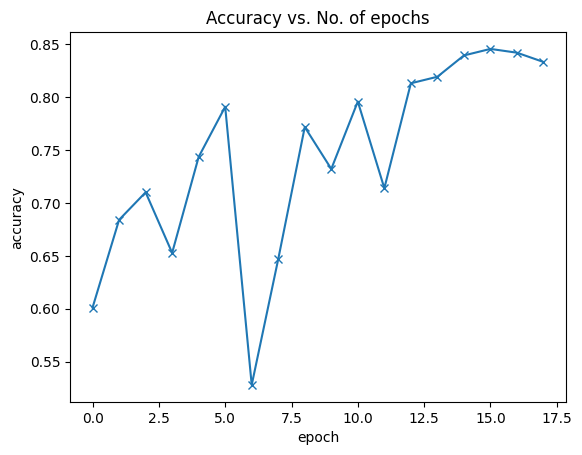

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_loss(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x.get('val_loss') for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training','Validation'])
    plt.title('Loss vs. No. of epochs');

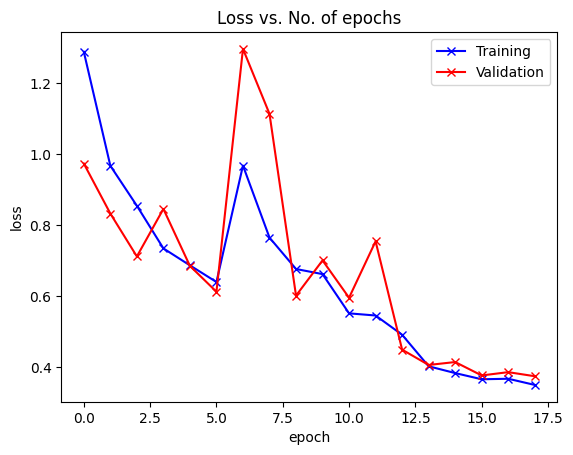

In [ ]:
plot_loss(history)

In [ ]:
num_epochs = 6
opt_func = torch.optim.Adam
lr = 0.0000000001
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 0.3540, val_loss: 0.3885, val_acc: 0.8370
Epoch [1], train_loss: 0.3547, val_loss: 0.3942, val_acc: 0.8247
Epoch [2], train_loss: 0.3582, val_loss: 0.3936, val_acc: 0.8422
Epoch [3], train_loss: 0.3541, val_loss: 0.3796, val_acc: 0.8396
Epoch [4], train_loss: 0.3526, val_loss: 0.3945, val_acc: 0.8344
Epoch [5], train_loss: 0.3592, val_loss: 0.3637, val_acc: 0.8484


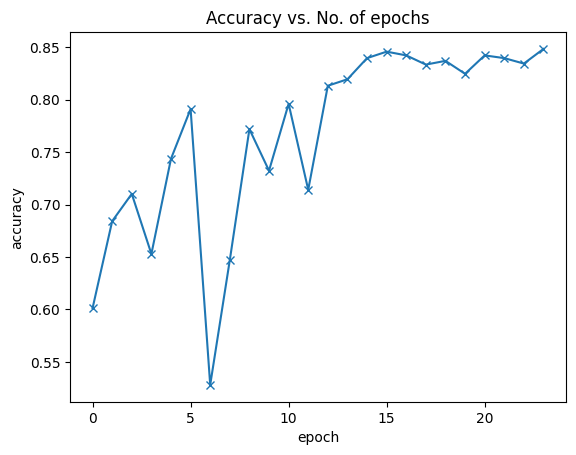

In [ ]:
plot_accuracies(history)

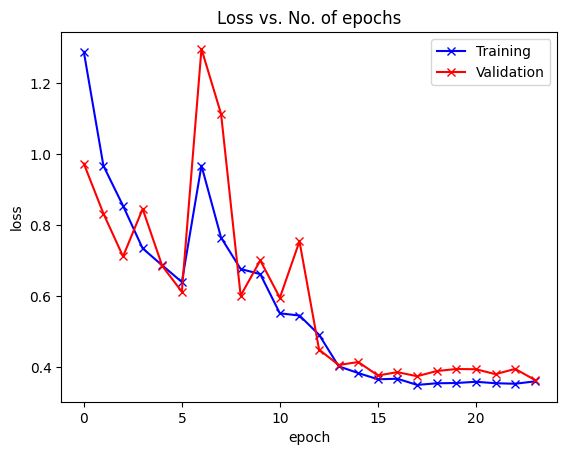

In [ ]:
plot_loss(history)

As we can see from the graph above, the model is trying to overfit the data and we can observe lower validation accuracy than the previous set of training.

From the above graph we can see the model is still learning and not overfitting, so we can try for a few more epochs with lower learning rate

#Predicting for test data

In [ ]:
def predict_image(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  # Pick index with highest probability
  _, preds  = torch.max(yb, dim=1)
  # Retrieve the class label
  return dataset.classes[preds[0].item()]

Actual Label: sunflower
Predicted Label: sunflower


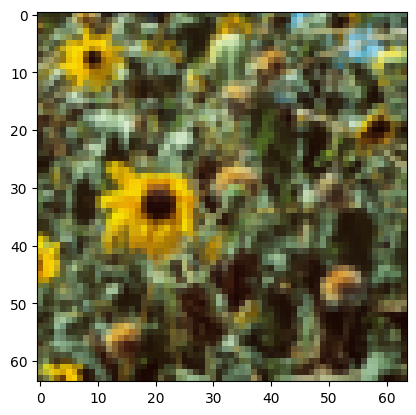

In [ ]:
for img,label in val_loader:
  img=img[15]
  label=label[15]
img=img.cpu()
plt.imshow(img.permute(1, 2, 0))
print('Actual Label:', dataset.classes[label])
print('Predicted Label:', predict_image(img, model))

Actual Label: daisy
Predicted Label: daisy


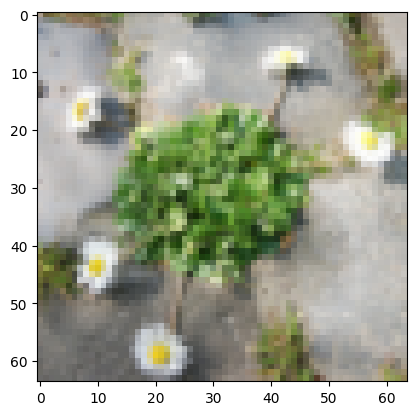

In [ ]:
for img,label in val_loader:
  img=img[0]
  label=label[0]
img=img.cpu()
plt.imshow(img.permute(1, 2, 0))
print('Actual Label:', dataset.classes[label])
print('Predicted Label:', predict_image(img, model))

Actual Label: tulip
Predicted Label: daisy


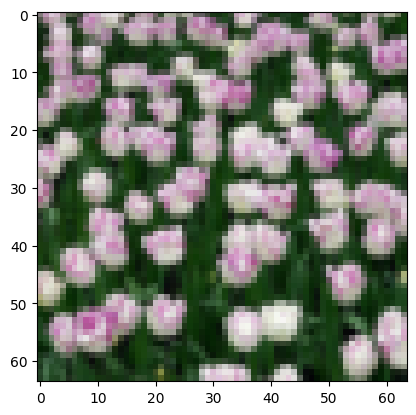

In [ ]:
for img,label in val_loader:
  img=img[1]
  label=label[1]
img=img.cpu()
plt.imshow(img.permute(1, 2, 0))
print('Actual Label:', dataset.classes[label])
print('Predicted Label:', predict_image(img, model))

Actual Label: rose
Predicted Label: rose


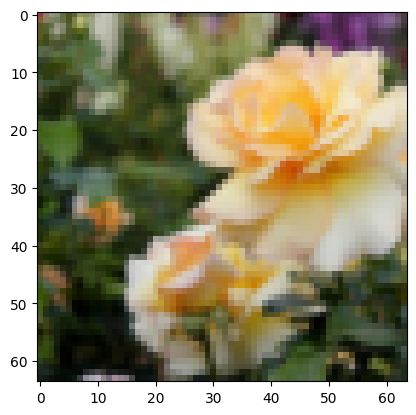

In [ ]:
for img,label in val_loader:
  img=img[44]
  label=label[44]
img=img.cpu()
plt.imshow(img.permute(1, 2, 0))
print('Actual Label:', dataset.classes[label])
print('Predicted Label:', predict_image(img, model))

Actual Label: tulip
Predicted Label: tulip


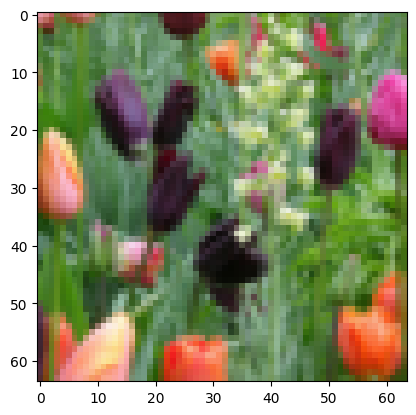

In [ ]:
for img,label in val_loader:
  img=img[26]
  label=label[26]
img=img.cpu()
plt.imshow(img.permute(1, 2, 0))
print('Actual Label:', dataset.classes[label])
print('Predicted Label:', predict_image(img, model))